In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation="nearest")
    plt.axis("off")

# Convolutional Layer

In [3]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

C:\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images

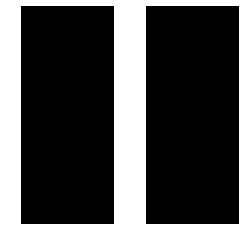

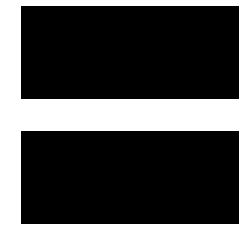

In [4]:
# filter
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [5]:
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [6]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X:images})

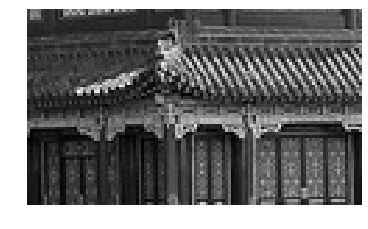

In [7]:
plot_image(images[0, :, :, 0])
plt.show()

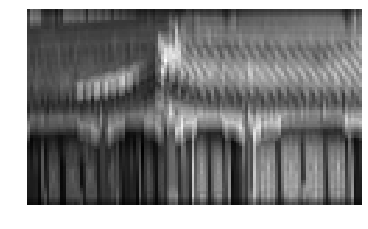

In [8]:
plot_image(output[0, :, :, 0])
plt.show()

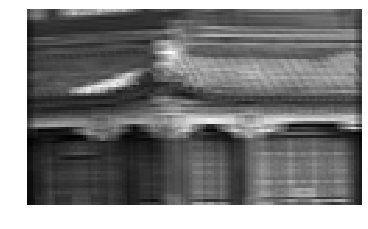

In [9]:
plot_image(output[0, :, :, 1])
plt.show()

# Max Pooling Layer

In [10]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# filters
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:, 3, :, 0] # vertical
filters[3, :, :, 1] # horizontal

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [11]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X:dataset})

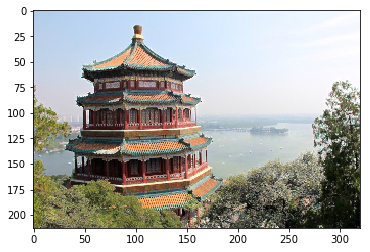

In [12]:
plt.imshow(output[0].astype(np.uint8))
plt.show()

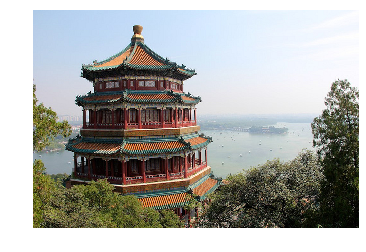

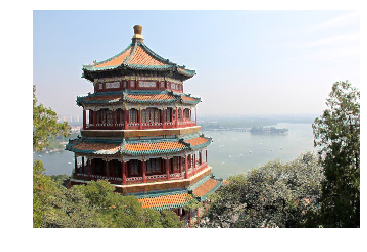

In [14]:
# original
plot_color_image(dataset[0])
plt.show()

# max pool
plot_color_image(output[0])
plt.show()

# CNN pada MNIST dataset

In [15]:
# initialize
height = 28
width = 28
channels = 1
n_inputs = width*height

# convolutional layer
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_padding = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_padding = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

In [17]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape=[None], name="y")

In [18]:
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_padding,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_padding,
                         activation=tf.nn.relu, name="conv2")

In [19]:
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

In [20]:
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

In [21]:
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits, name="y_proba")

In [22]:
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

In [23]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [26]:
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [27]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [28]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [30]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_valid = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        
        save_path = saver.save(sess, "./my_mnist_model.ckpt")

0 Batch accuracy: 0.97 Validation accuracy: 0.9742
1 Batch accuracy: 0.99 Validation accuracy: 0.9828
2 Batch accuracy: 1.0 Validation accuracy: 0.9842
3 Batch accuracy: 1.0 Validation accuracy: 0.987
4 Batch accuracy: 1.0 Validation accuracy: 0.9874
5 Batch accuracy: 0.99 Validation accuracy: 0.9866
6 Batch accuracy: 1.0 Validation accuracy: 0.9878
7 Batch accuracy: 1.0 Validation accuracy: 0.9886
8 Batch accuracy: 1.0 Validation accuracy: 0.99
9 Batch accuracy: 1.0 Validation accuracy: 0.9862


In [31]:
# test
model_path = "./my_mnist_model.ckpt"

with tf.Session() as sess:
    saver.restore(sess, model_path)
    accuracy_test = accuracy.eval(feed_dict={X:X_test, y:y_test})

INFO:tensorflow:Restoring parameters from ./my_mnist_model.ckpt


In [32]:
accuracy_test

0.9894